In [ ]:
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras import backend as K
from sklearn import preprocessing
from keras.utils import np_utils
#from sklearn.cross_validation import StratifiedKFold
import os, math
import gdal
from copy import deepcopy
import pandas as pd
from numpy import save
!pip install patchify
from patchify import patchify, unpatchify

In [ ]:
def readraster(file):
    dataSource = gdal.Open(file)
    band = dataSource.ReadAsArray()
    return(dataSource, band)

In [ ]:
os.chdir("/content/drive/MyDrive/Project_file2")
# Input land cover GeoTIFF for two time period
file1 = "dist_clip.tif"
file2 = "dist_classification1.tif"
ds_lc1, arr_lc1 = readraster(file1)
ds_lc2, arr_lc2 = readraster(file2)

In [ ]:
image = arr_lc1
image = np.reshape(image, (image.shape[1],image.shape[2], image.shape[0]))

In [ ]:
print(image.shape)

(667, 1141, 4)


In [ ]:
newX = np.reshape(image, (-1, image.shape[2])) 
print(newX.shape)

(761047, 4)


In [ ]:
scaler = preprocessing.StandardScaler().fit(newX)  
newX = scaler.transform(newX) 

In [ ]:
newX = np.reshape(newX, (image.shape[0],image.shape[1],image.shape[2]))

In [ ]:
image_patches = patchify(newX, (3,3,4), step=1) 

In [ ]:
class_patches = patchify(arr_lc2, (3,3), step=1) 

In [ ]:
image_patches = np.reshape(image_patches, (image_patches.shape[0]*image_patches.shape[1]* image_patches.shape[2],image_patches.shape[3],image_patches.shape[4],image_patches.shape[5]))

In [ ]:
class_patches1 = np.reshape(class_patches, (class_patches.shape[0] * class_patches.shape[1], class_patches.shape[2], class_patches.shape[3]))

In [ ]:
print(image_patches.shape)

(757435, 3, 3, 4)


In [ ]:
print(class_patches1.shape)

(757435, 3, 3)


In [ ]:
import matplotlib.pyplot as plt

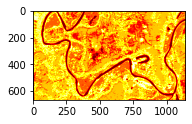

In [ ]:
plt.subplot(121)
plt.imshow(arr_lc2,cmap="hot")

In [ ]:
train_center_pixel= []
x = 0
for i in range(757435):
    train_center_pixel.append(class_patches1[x][1][1])
    x= x+1

In [ ]:
train_center_pixel = np.array(train_center_pixel)

In [ ]:
(unique, counts) = np.unique(arr_lc2, return_counts=True)
class_patches = np.array((unique, counts)).T
print(class_patches)

[[     0   5572]
 [     1  54735]
 [     2  94123]
 [     3 150241]
 [     4 258296]
 [     5  77583]
 [     6 120497]]


In [ ]:
print(arr_lc2.shape)

(667, 1141)


In [ ]:
class_new=(arr_lc2 == 4).astype(int)

In [ ]:
print(class_new.shape)

(667, 1141)


In [ ]:
(unique, counts) = np.unique(class_new, return_counts=True)
class_patches = np.array((unique, counts)).T
print(class_patches)

[[     0 502751]
 [     1 258296]]


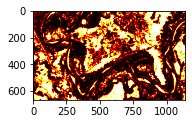

In [ ]:
plt.subplot(121)
plt.imshow(class_new,cmap="hot")

In [ ]:
from PIL import Image

In [ ]:
import matplotlib
matplotlib.image.imsave('/content/drive/MyDrive/Project_file2/crop_2015.tiff',class_new)

In [ ]:
print(image_patches.shape)
print(train_center_pixel.shape)

(757435, 3, 3, 4)
(757435,)


In [ ]:
image_patches = np.reshape(image_patches, (image_patches.shape[0],image_patches.shape[3],image_patches.shape[2],image_patches.shape[1]))
print("shape reshaspe :" +str(image_patches.shape))

shape reshaspe :(757435, 4, 3, 3)


In [ ]:
testRatio=0.05
def splitTrainTestSet(X, y, testRatio=0.20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,stratify=y)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = splitTrainTestSet(image_patches, train_center_pixel, testRatio)

In [ ]:
input_shape = image_patches[0].shape
print(input_shape)

(4, 3, 3)


In [ ]:
# convert class labels to on-hot encoding
y_train1 = np_utils.to_categorical(y_train)
print(y_train1.shape)

(719563, 7)


In [ ]:
from keras.layers import BatchNormalization

In [ ]:
# Define the model
model = Sequential()
model.add(Conv1D(32, 1, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv1D(128, 1, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv1D(256, 1, activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 3, 32)          128       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 3, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 3, 64)          2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 3, 64)          256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 3, 128)         8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 3, 128)         512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 3, 256)         3

In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train1, batch_size=32, epochs=1) #model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5)

22487/22487 [==============================] - 1048s 47ms/step - loss: 1.7161 - accuracy: 0.3316
